# Radiometer Parsing Function

This code shows an example of reading in and plotting data that is outputted from the Software Defined Radio based radiometer.  In this example total power measurements from the SDR-based radiometer is recorded to a file.  This file is then read using python scripts shown in this notebook.  A calibration file is also created based on data collected for this experiment.  The calibration file is then used to collaborate the total power measurements to a noise temperature.

In this experiment, a 50-ohm matched load that starts at room temperature, is submerged in ice water, and then submerged Liquid Nitrogen.  This experiment is similar to Experiment I outlined in the thesis in Section 5.1.
- - -

## Read the data

We begin by importing needed functions in Python.  Specifically SciPy, NumPy and CSV.  SciPy and NumPy allows us to read the binary file and perform numerical analysis.  CSV allows us to read our comma delimited calibration file.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy
import numpy
import scipy.io as sio
import csv

Use this to set the filename for the data files and CSV Calibration file.

In [3]:
tpr = 'tpr_2014.06.12.Lab0.dat'
calib = 'tpr_calib_2014.06.12.Lab0.csv'
x2_data = 'tpr_x2_2014.06.12.Lab0.csv'

Uses SciPy to open the binary file from GNURadio

In [4]:
tpr_data = scipy.fromfile(open(tpr),dtype=scipy.float32)

Because of the valve function in GNURadio, there are zeros that get added to the file.  We want to trim out those zeros.

In [5]:
tpr_data = numpy.trim_zeros(tpr_data)

Create an index array for plotting.  Also, since we know the interval the data is taken, we can convert this to an actual time.

In [6]:
y = numpy.linspace(0,(len(tpr_data)*.46),numpy.size(tpr_data))

## Plot the data

In [7]:
matplotlib.rcParams.update({'font.size': 18, 'text.usetex': True})

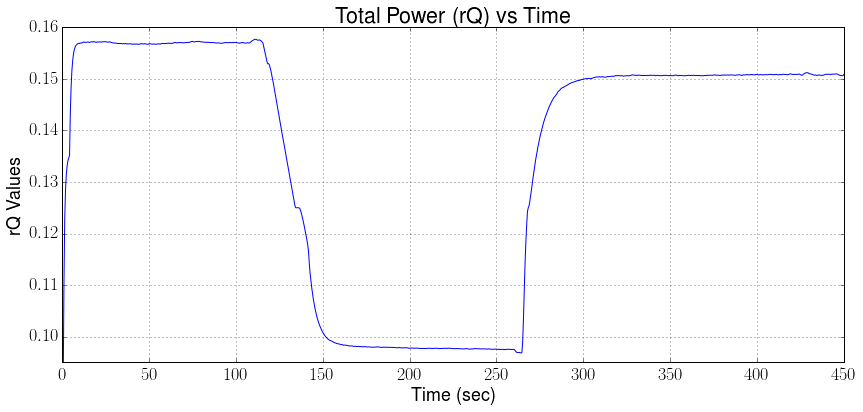

In [8]:
fig = plt.figure(figsize=(14,6), dpi=300)
plot(y,tpr_data)
xlabel('Time (sec)')
ylabel('rQ Values')
title('Total Power (rQ) vs Time')
axis([0, 450, .095, .16])
grid(True)
fig.savefig("tprvstime.pdf", dpi=300)
fig.savefig("tprvstime.png", dpi=300)

## Calibration

The rQ values are the raw values from the total power radiometer and are uncalibrated.  While the graph shows the change in the total power recorded and shows that the radiometer can detect changes in noise temperature, it has no other meaning than that.  What we want is to show what the total power is in relation to a noise temperature.  Since we have recorded the values of the rQ at fixed and known teperatures, we can create a calibration line and calibrate the radiometer.  For this experiment, we found that the following values matched our two known temperatures.

|rQ Value|X^2 Voltage|Temperature
|--------|-----------------------
|.0977   | 1.9617    |77 K
|.1507   | 2.085     |273.15 K

We can now solve for y = mx + b since we have two equations and two unknowns.

To work with this, a calibration file is created.  This is a very simple CSV file that contains 3 values: The raw rQ value, the raw voltage from the square-law detector (discussed later) and the observed temperature.  The table above would then look like the following in the file.
```
.0977,1.9617,77
.1507,2.085,273.15
```
- - -

We need to read in the values from our CSV file that contains the values

In [9]:
read_csv = open(calib, 'rb')
csvread = csv.reader(read_csv)
rQ_values = []
temp_values = []
voltage = []

for row in csvread:
    rQ,volt,temp = row
    rQ_values.append(float(rQ))
    voltage.append(float(volt))
    temp_values.append(float(temp))
read_csv.close()

In [10]:
a = numpy.array([[rQ_values[0],1.0],[rQ_values[1],1.0]],numpy.float32)
b = numpy.array([temp_values[0],temp_values[1]])

In [11]:
z = numpy.linalg.solve(a,b)
print z

[ 3700.9431798   -284.58214796]


Now we apply these values to the array that holds our raw rQ values

In [12]:
tpr_calib = tpr_data*z[0]+z[1]

Now we can re-plot the graph but this time with the calibrated noise temperatures

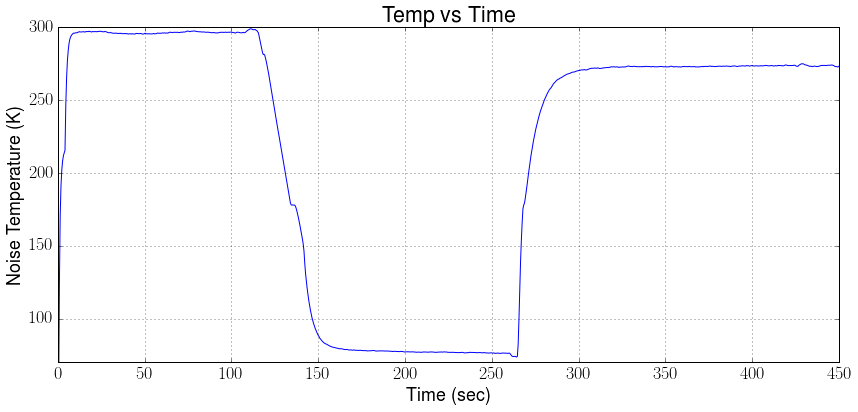

In [13]:
fig = plt.figure(figsize=(14,6), dpi=300)
plot(y,tpr_calib)
xlabel('Time (sec)')
ylabel('Noise Temperature (K)')
title('Temp vs Time')
axis([0, 450, 70, 300])
grid(True)
fig.savefig("tprcalibvstime.pdf", dpi=300)
fig.savefig("tprcalibvstime.png", dpi=300)